In [1]:
import pyro
from pyro import distributions as dist
import pyro.distributions.constraints as constraints
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
import pyro.contrib.gp as gp
from sklearn.datasets import fetch_olivetti_faces
from tqdm.autonotebook import tqdm
from torch import nn
from torch.nn import Parameter
from pyro.nn.module import PyroParam

In [2]:
pyro.clear_param_store()

In [3]:
x_train, y_train = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=97)


In [4]:
Y = (x_train)*255
Y = Y.astype(int)
Y = torch.tensor(Y)

In [5]:
idx = torch.linspace(-32, 32, 64, dtype=torch.float)
idx2 = torch.linspace(-32, 32, 24, dtype=torch.float)
X = torch.cartesian_prod(idx, idx)
Xu = torch.cartesian_prod(idx2, idx2)

In [6]:
X.shape

torch.Size([4096, 2])

In [7]:
class LinearT(nn.Module):
    """Linear transform and transpose"""
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)

    def forward(self, x):
        return self.linear(x).T

In [8]:
class LinearExp(gp.Parameterized):
    def __init__(self, dim_in, dim_out):
        super(LinearExp, self).__init__()

        self.W = PyroParam(torch.rand(dim_out, dim_in), constraint=constraints.positive)
    
    def forward(self, x):
        x = torch.exp(x)
        x = torch.matmul(self.W, x)
        return x

In [9]:
L = 10
likelihood_mean = LinearExp(L, Y.shape[0])

likelihood = gp.likelihoods.Poisson(response_function=likelihood_mean)
mean_fn = LinearT(2, L)
kernel = gp.kernels.RBF(2, variance=torch.tensor(1.), lengthscale=torch.tensor(0.1))
gpr = gp.models.VariationalSparseGP(X, Y, kernel=kernel, Xu=Xu, likelihood=likelihood, mean_function=mean_fn, latent_shape=torch.Size([L]), jitter=1e-2)
# gpr = gp.models.VariationalSparseGP(X, Y, kernel=kernel, Xu=Xu, likelihood=likelihood,  latent_shape=torch.Size([L]), jitter=1e-2)

In [10]:
Xu.shape

torch.Size([576, 2])

In [11]:
gpr.u_loc.shape

torch.Size([10, 576])

In [12]:
Y.shape

torch.Size([400, 4096])

In [13]:
X.shape

torch.Size([4096, 2])

In [14]:
# model = NSF(X, Y, Xu)

In [15]:
gpr.parameters

<bound method Module.parameters of VariationalSparseGP(
  (kernel): RBF()
  (mean_function): LinearT(
    (linear): Linear(in_features=2, out_features=10, bias=False)
  )
  (likelihood): Poisson(
    (response_function): LinearExp()
  )
)>

In [16]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=1e-2)
loss_fn = pyro.infer.TraceMeanField_ELBO(num_particles=10, vectorize_particles=True).differentiable_loss

In [17]:
# do gradient steps
losses = []
for step in tqdm(range(2000)):
    optimizer.zero_grad()
    gpr.set_data(X, Y)
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

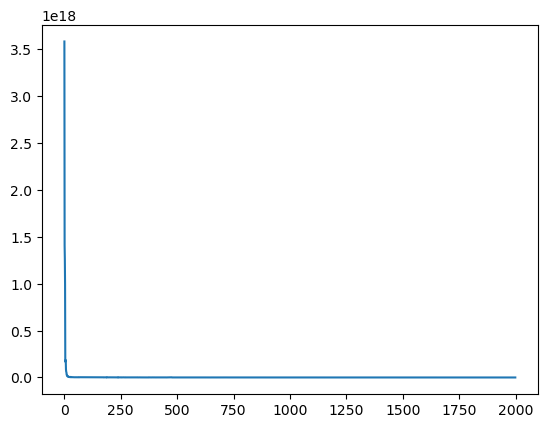

In [18]:
plt.plot(losses)

In [19]:
likelihood_mean.W

tensor([[0.4773, 0.3122, 0.2074,  ..., 0.7586, 0.6426, 0.0135],
        [0.3928, 0.5424, 0.0167,  ..., 0.2213, 0.4576, 0.6202],
        [0.2372, 0.2568, 0.0530,  ..., 0.7093, 0.3188, 0.0410],
        ...,
        [0.2410, 0.2420, 0.3483,  ..., 0.3091, 0.2403, 0.1827],
        [0.8024, 0.3051, 0.7614,  ..., 0.5665, 0.1383, 0.7467],
        [0.6734, 0.1435, 0.4158,  ..., 0.4214, 0.5599, 0.5122]],
       grad_fn=<AddBackward0>)

In [20]:
F, _ = gpr.forward(X)

In [21]:
F.shape

torch.Size([10, 4096])

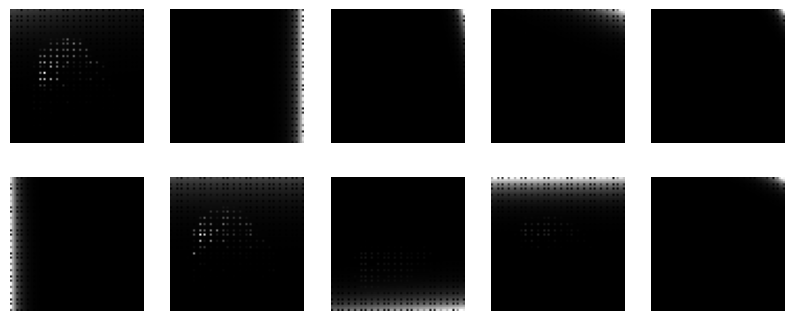

In [22]:
plt.figure(figsize=(10, L*2//5))
for i in range(L):
    plt.subplot(L//5, 5, i+1)
    loading = (F[i].exp()).detach().cpu().numpy()
    plt.imshow(loading.reshape(64, 64), cmap='gray')
    plt.axis('off')